In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, Dense, Dropout, GlobalAveragePooling2D,
                                     MaxPooling2D, LayerNormalization, MultiHeadAttention,
                                     DepthwiseConv2D, BatchNormalization, Add, Reshape)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image
import datetime

# Paths and Parameters
root_dir = "/kaggle/input/cervical-cancer-largest-dataset-sipakmed/"
paths = [
    os.path.join(root_dir, "im_Dyskeratotic", "im_Dyskeratotic", "CROPPED"),
    os.path.join(root_dir, "im_Koilocytotic", "im_Koilocytotic", "CROPPED"),
    os.path.join(root_dir, "im_Metaplastic", "im_Metaplastic", "CROPPED"),
    os.path.join(root_dir, "im_Parabasal", "im_Parabasal", "CROPPED"),
    os.path.join(root_dir, "im_Superficial-Intermediate", "im_Superficial-Intermediate", "CROPPED")
]

height, width, channels = 64, 64, 3
num_classes = len(paths)

# Load images from folders
def load_images_from_paths(paths, img_size=(height, width)):
    images = []
    labels = []
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')
    for idx, p in enumerate(paths):
        if not os.path.exists(p):
            print(f"Warning: path not found {p}")
            continue
        for file in os.listdir(p):
            if not file.lower().endswith(valid_extensions):
                continue
            try:
                img_path = os.path.join(p, file)
                img = Image.open(img_path).convert('RGB').resize(img_size)
                img = np.array(img).astype(np.float32) / 255.0
                if img.shape != (height, width, channels):
                    continue
                images.append(img)
                labels.append(idx)
            except Exception as e:
                print(f"Failed loading {file}: {e}")
                continue
    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32)

# Load data and labels
data, labels = load_images_from_paths(paths)

# One-hot labels for training neural net
labels_one_hot = tf.one_hot(labels, depth=num_classes).numpy()

# Train/val/test split
X_train, X_tmp, y_train, y_tmp = train_test_split(data, labels_one_hot, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=np.argmax(y_tmp, axis=1))

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# CoAtNet Components
def conv_bn(x, filters, kernel_size, strides, padding="same"):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization()(x)
    return x

def coatnet_block(x, filters, kernel_size=3, strides=1, num_heads=2, expansion=4):
    conv = conv_bn(x, filters, kernel_size, strides)
    conv = conv_bn(conv, filters, kernel_size, strides)

    pooled = tf.keras.layers.AveragePooling2D(pool_size=4)(x)
    batch_size = tf.shape(pooled)[0]
    height = pooled.shape[1]
    width = pooled.shape[2]
    channels = pooled.shape[3]
    spatial_dim = height * width

    attn = Reshape((spatial_dim, channels))(pooled)
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=channels)(attn, attn)
    attn = Dense(filters)(attn)
    attn = Reshape((height, width, filters))(attn)
    attn = tf.image.resize(attn, (x.shape[1], x.shape[2]))

    combined = Add()([conv, attn])
    return BatchNormalization()(combined)

# CoAtNet Model
def create_coatnet_model(input_shape=(height, width, channels), num_classes=num_classes):
    inputs = Input(shape=input_shape)

    x = conv_bn(inputs, 32, 3, strides=1)
    x = coatnet_block(x, 64, kernel_size=3, strides=1, num_heads=4)
    x = coatnet_block(x, 128, kernel_size=3, strides=1, num_heads=4)
    x = coatnet_block(x, 256, kernel_size=3, strides=1, num_heads=4)

    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# Build and compile the model
model = create_coatnet_model()

# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_coatnet_model.keras", monitor="val_accuracy", save_best_only=True, mode="max")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=80, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs= 200,
    callbacks=[checkpoint, early_stopping, reduce_lr, tensorboard_cb]
)

# Load best weights
model.load_weights("best_coatnet_model.keras")

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/200
89/89 [==============================] - 34s 234ms/step - loss: 1.1902 - accuracy: 0.5653 - val_loss: 1.5995 - val_accuracy: 0.4300
Epoch 2/200
89/89 [==============================] - 17s 186ms/step - loss: 0.7635 - accuracy: 0.7339 - val_loss: 3.3718 - val_accuracy: 0.2603
Epoch 3/200
89/89 [==============================] - 17s 190ms/step - loss: 0.6094 - accuracy: 0.7848 - val_loss: 2.1349 - val_accuracy: 0.3328
Epoch 4/200
89/89 [==============================] - 17s 194ms/step - loss: 0.5252 - accuracy: 0.8169 - val_loss: 0.6711 - val_accuracy: 0.7644
Epoch 5/200
89/89 [==============================] - 18s 200ms/step - loss: 0.5194 - accuracy: 0.8109 - val_loss: 0.8159 - val_accuracy: 0.6952
Epoch 6/200
89/89 [==============================] - 18s 208ms/step - loss: 0.4666 - accuracy: 0.8380 - val_loss: 0.5569 - val_accuracy: 0.7974
Epoch 7/200
89/89 [==============================] - 19s 214ms/step - loss: 0.4460 - accuracy: 0.8409 - val_loss: 0.8953 - val_accuracy:

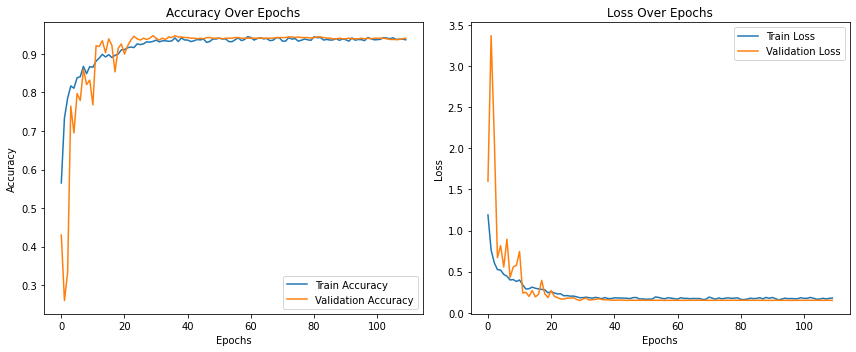

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# --- Visualize Training History ---
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()



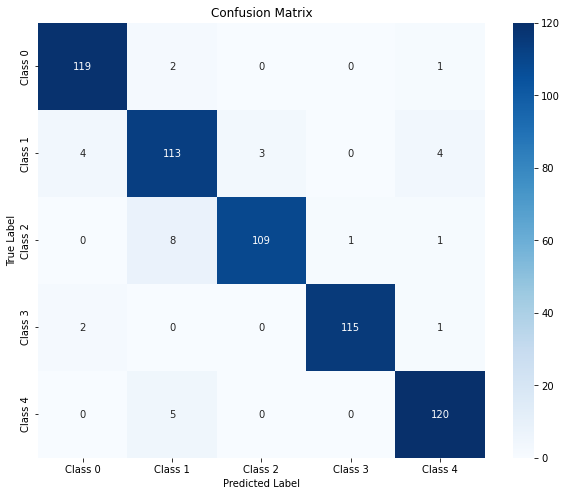

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.95      0.98      0.96       122
     Class 1       0.88      0.91      0.90       124
     Class 2       0.97      0.92      0.94       119
     Class 3       0.99      0.97      0.98       118
     Class 4       0.94      0.96      0.95       125

    accuracy                           0.95       608
   macro avg       0.95      0.95      0.95       608
weighted avg       0.95      0.95      0.95       608



In [3]:
# --- Confusion Matrix ---
# Convert predictions and true labels to integer labels
y_test_int = np.argmax(y_test, axis=1)
y_test_pred_probs = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test_int, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Class {i}' for i in range(num_classes)],
            yticklabels=[f'Class {i}' for i in range(num_classes)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test_int, y_test_pred, target_names=[f'Class {i}' for i in range(num_classes)]))

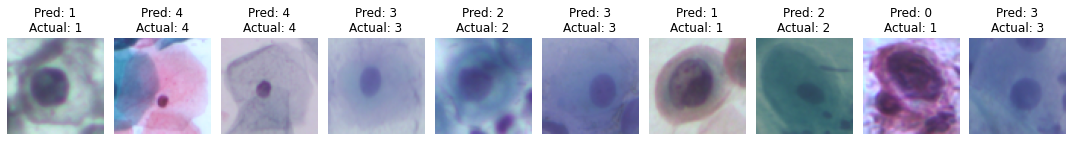

In [4]:
# --- Display Images with Predictions ---
def display_images_with_predictions(X_test, y_test_pred, y_test_int, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X_test[i])
        plt.title(f"Pred: {y_test_pred[i]}\nActual: {y_test_int[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Display 10 random predictions with actual labels
num_images = 10
indices = np.random.choice(len(X_test), num_images, replace=False)
display_images_with_predictions(X_test[indices], y_test_pred[indices], y_test_int[indices], num_images=num_images)


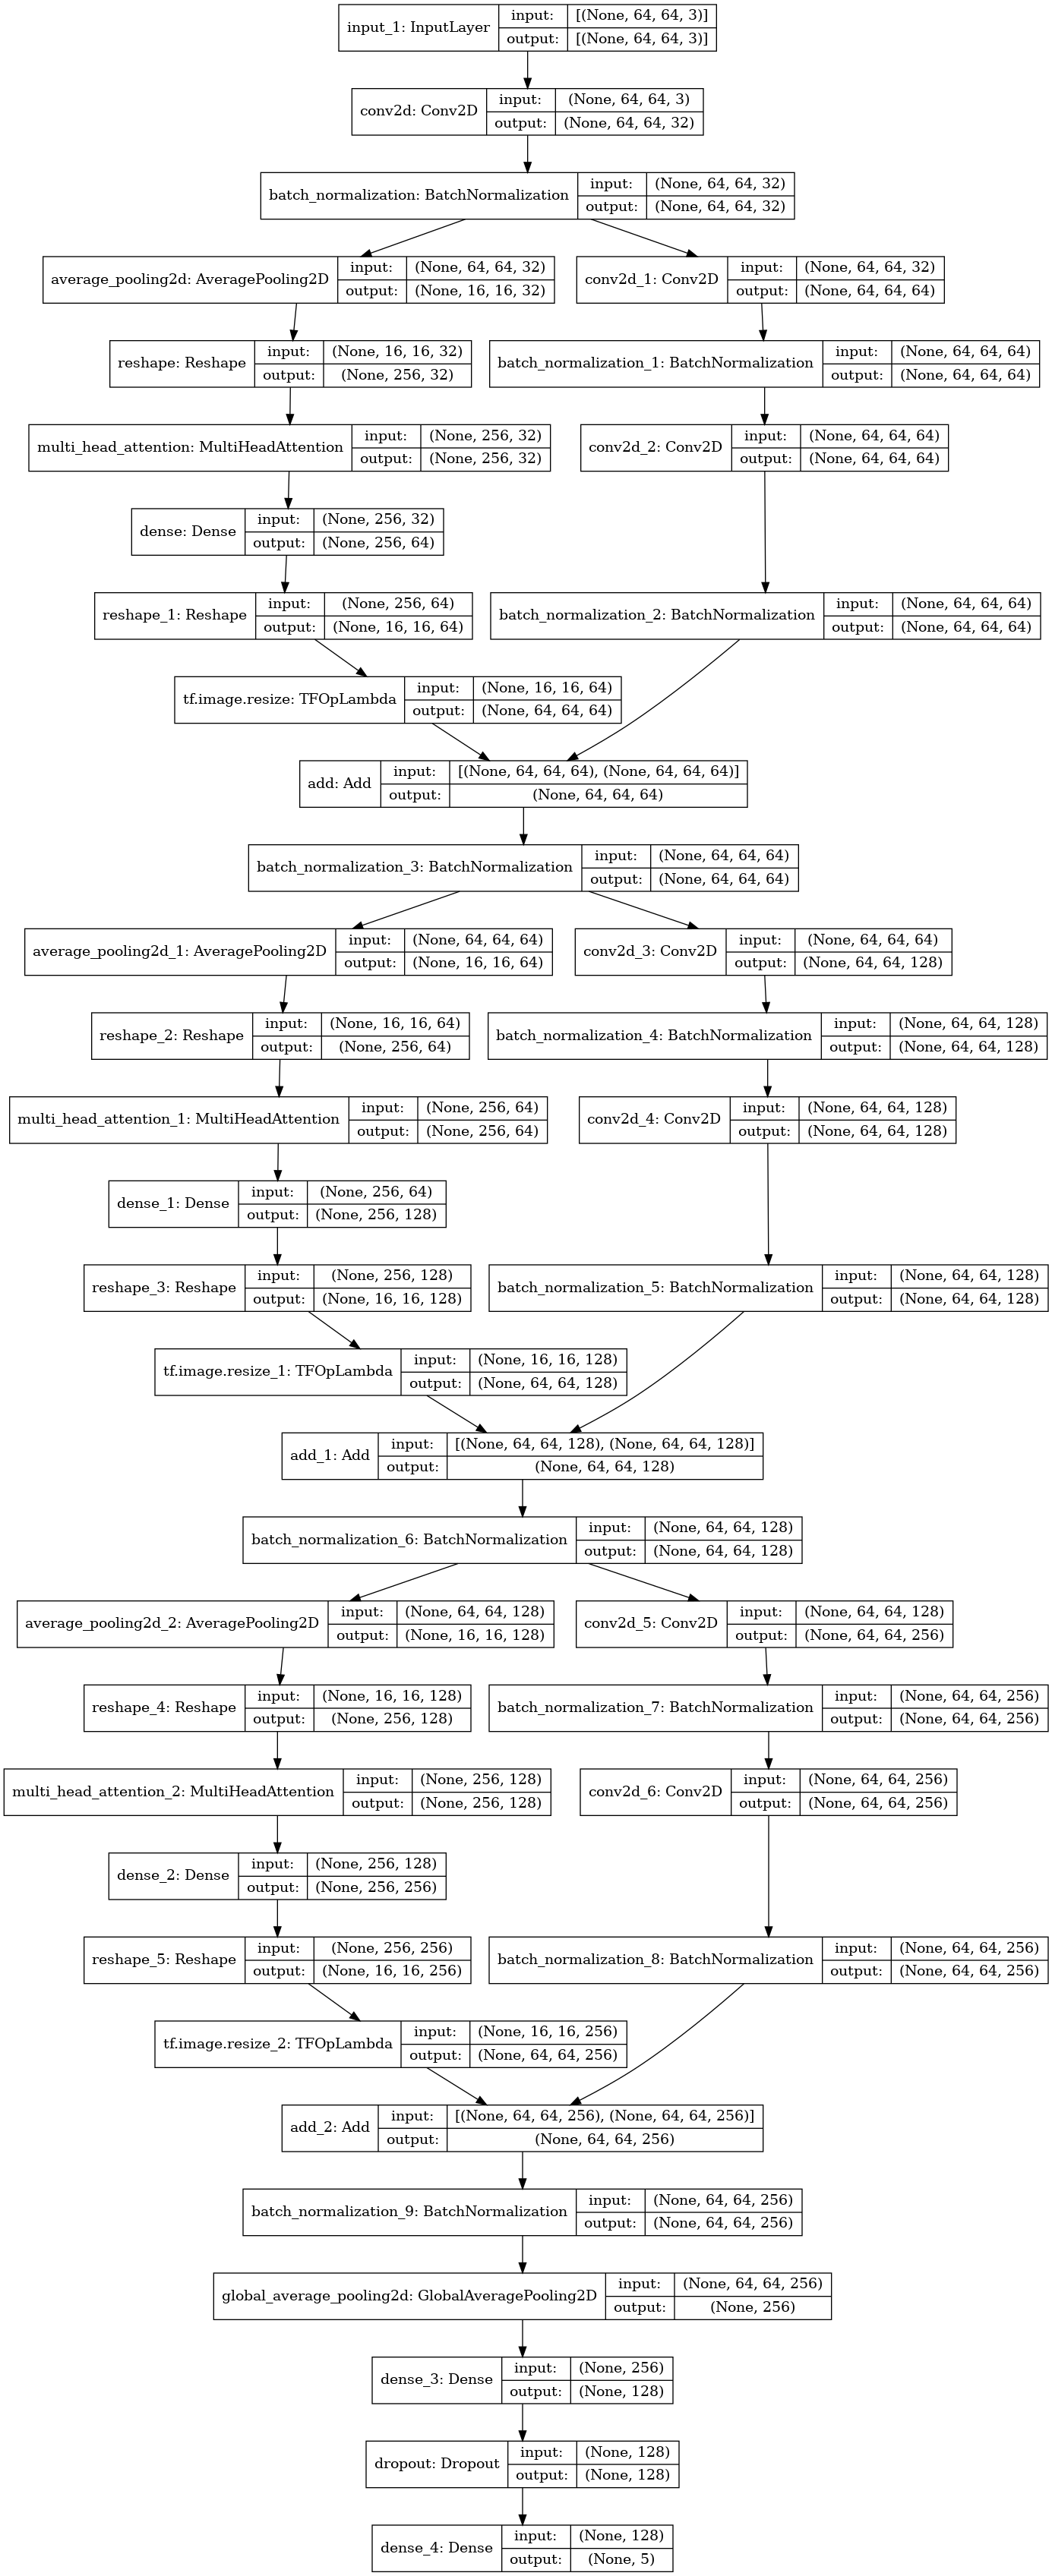

In [5]:
from tensorflow.keras.utils import plot_model
import os
plot_model(model, to_file='train_model.png', show_shapes=True, show_layer_names=True)